In [16]:
import numpy as np
import pandas as pd
import h5py
import os
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
from utils import *

In [17]:
# General settings
import matplotlib as mpl
mpl.rc_file('/Users/ulyanadupletsa/Documents/PhDThesisPlots/matplotlibrc')

mpl.rc('xtick', labelsize = 21) 
mpl.rc('ytick', labelsize = 21)

In [18]:
my_color = '#97a7a7'
my_color_darker = '#2f4f4f'
my_color2 = '#f8c997'
my_color2_darker = '#f6b26b'

In [19]:
user = 'ulyanadupletsa'

In [20]:
PATH_TO_LINEAR_CLS = '/Users/' + str(user) + '/Documents/Radio-Sirens/class_output/'
PATH_TO_MAPS = '/Users/' + str(user) + '/Documents/Radio-Sirens/maps/'

# general settings
lmax =192
nside = int(lmax/3)
npix = hp.nside2npix(nside)

In [21]:
# get redshift range from GADGET maps
def get_z_range():
    z_range = []
    for file in os.listdir(PATH_TO_MAPS + 'mass_maps/'):
        name_strips = file.split('_')
        zmin, zmax= name_strips[3][4:8], name_strips[4][4:8]
        zmean = np.round((float(zmin) + float(zmax))/2, 3)
        z_range.append(np.float64(zmean))
    z_range = np.array(z_range)
    return np.float64(z_range)

In [22]:
zz = get_z_range()
zz = np.sort(zz)

In [23]:
# linear Cls
zmin = zz[0]
zmax = zz[-1]
linear_cls_file = PATH_TO_LINEAR_CLS + 'linear_cls_zmin' + str(zmin) + '_zmax' + str(zmax) + '_lmax' + str(lmax) + '.dat'
linear_cls = read_Cls_from_class(linear_cls_file, lmax, len(zz), diag=False)

In [24]:
#halofit Cls
cls = {}
halo_data = {}
halo_map = {}
shot_noise = {}
mean_halo_mass_per_pix = {}
np.random.seed(42)
for file in os.listdir(PATH_TO_MAPS + 'mass_maps/'):
    # strip string to get the redshit range out of the name of the map
    name_strips = file.split('_')
    snapshot, zmin_halo, zmax_halo, nside_halo = name_strips[2][8:10], name_strips[3][4:8], name_strips[4][4:8], name_strips[5][5:8]
    zmean_halo = np.round((float(zmin_halo) + float(zmax_halo))/2, 3)
    halo_data[str(zmean_halo)] = np.loadtxt(PATH_TO_MAPS + 'mass_maps/' + file)
    # REMEMBER TO USE THE ORIGINAL PIXELIZATION
    mean_halo_mass_per_pix[str(zmean_halo)] = np.sum(halo_data[str(zmean_halo)])/len(halo_data[str(zmean_halo)])

    halo_map[str(zmean_halo)] = (halo_data[str(zmean_halo)] - mean_halo_mass_per_pix[str(zmean_halo)])/mean_halo_mass_per_pix[str(zmean_halo)]
    shot_noise[str(zmean_halo)] = np.sum(halo_data[str(zmean_halo)]**2)/(np.sum(halo_data[str(zmean_halo)])**2)
    cls[str(zmean_halo)] = hp.anafast(halo_map[str(zmean_halo)], lmax=lmax) 

In [25]:
# make a copy of original cls
cls_sorted = cls.copy()
cls_sorted = dict(sorted(cls_sorted.items()))

shot_noise_sorted = shot_noise.copy()
shot_noise_sorted = dict(sorted(shot_noise_sorted.items()))

non_linear_cls_denoised = {}
for i, z in enumerate(zz):
    non_linear_cls_denoised[str(z)] = cls_sorted[str(z)] - shot_noise_sorted[str(z)]

In [26]:
ells = np.linspace(0, lmax, lmax+1)
# normalize both cls 
linear_cls_norm = {}
non_linear_cls_norm = {}
for i, key in enumerate(cls_sorted.keys()):
    linear_cls_norm[key] = linear_cls['z_bin' + str(i+1)].to_numpy()/np.sum((2*ells+1)*linear_cls['z_bin' + str(i+1)].to_numpy())
    non_linear_cls_norm[key] = non_linear_cls_denoised[key]/np.sum((2*ells+1)*non_linear_cls_denoised[key])

/var/folders/h7/9cf4n2f137zdvy422j_dnbcw0000gn/T/ipykernel_24636/1068629745.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[i].legend(title='z = ' + key, title_fontsize=myfontsize-4, frameon=False, loc='upper right')


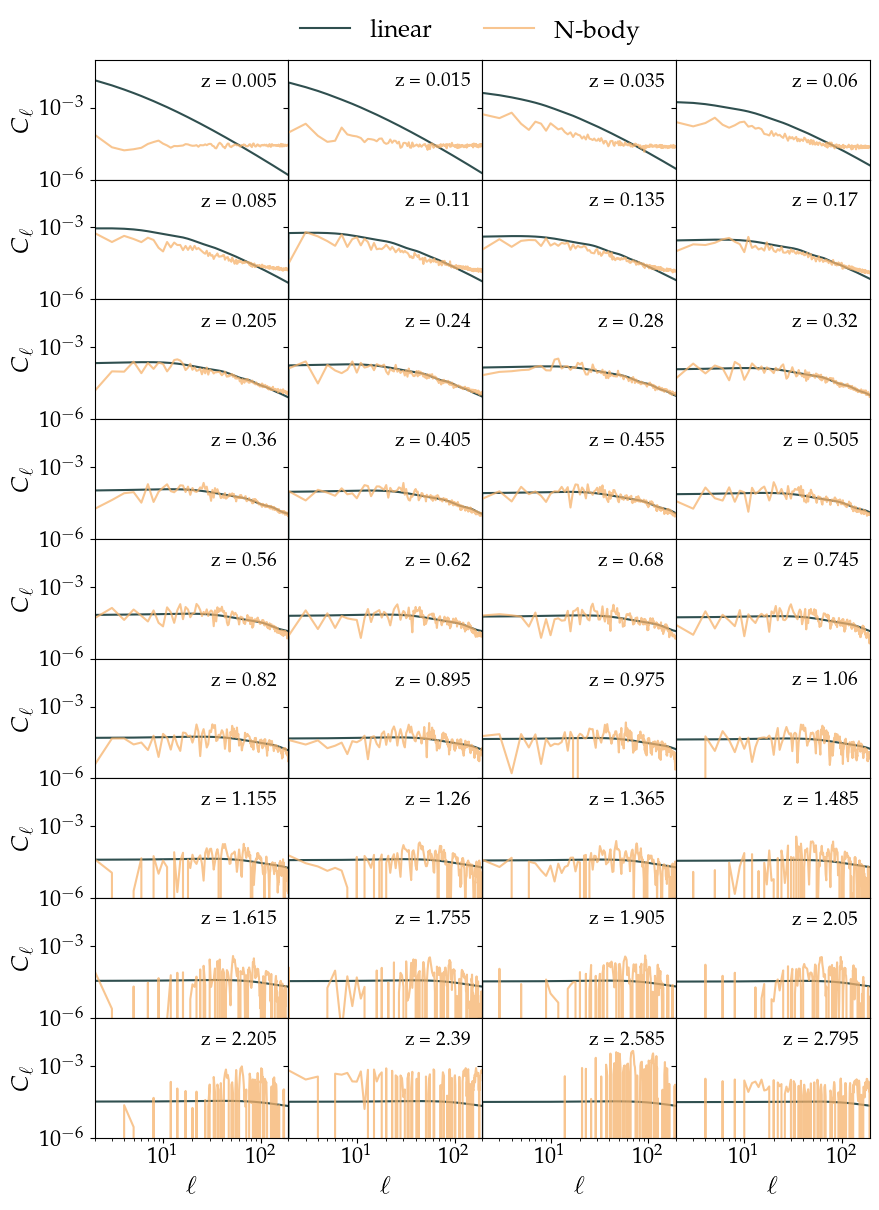

In [27]:
myfontsize=18
# plot all redshifts at once to compare linear and halofit Cls
fig, axs = plt.subplots(9, 4, figsize=(10,14), sharex=True, sharey=True)
axs = axs.ravel()
for i, key in enumerate(cls_sorted.keys()):
    if i==36:
        break
    axs[i].loglog(ells, linear_cls_norm[key], color=my_color_darker, linewidth=1.5)
    axs[i].loglog(ells, non_linear_cls_norm[key], color=my_color2_darker, alpha=0.75)
    axs[i].set_xlim(2, lmax)
    axs[i].set_ylim(1e-6, 1e-1)
    axs[i].legend(title='z = ' + key, title_fontsize=myfontsize-4, frameon=False, loc='upper right')
    
    

for i in (0,4,8,12,16,20,24,28,32):
    axs[i].set_ylabel('$C_{\ell}$', fontsize=myfontsize)
    axs[i].tick_params(axis='y', labelsize=16)
for i in range(32, 36):
    axs[i].set_xlabel('$\ell$', fontsize=myfontsize)
    axs[i].tick_params(axis='x', labelsize=16)
fig.legend(['linear', 'N-body'], loc='upper center', bbox_to_anchor=(0.5, 0.925), 
           ncol=2, frameon=False, fontsize=myfontsize)

plt.subplots_adjust(wspace=0, 
                    hspace=0)
plt.savefig('plots/linear_vs_nonlinear_cls.pdf', bbox_inches='tight')
plt.show()
